In [1]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

In [2]:
import torch
import torch.backends.cudnn as cudnn
import random
import numpy as np

# seeds
seed = 88
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
cudnn.deterministic = True
cudnn.benchmark = False
torch.use_deterministic_algorithms(True)
g = torch.Generator()
g.manual_seed(seed)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [3]:
from torchvision.datasets import FGVCAircraft
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# remove copyright banner
class RemoveCopyrightBanner(object):
    def __call__(self, img):
        width, height = img.size
        return img.crop((0, 0, width, height - 20))

transform = transforms.Compose([
    RemoveCopyrightBanner(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create the FGVC Aircraft dataset instance
train_dataset = FGVCAircraft(
    root='./data',
    split='trainval',              # Options: 'train', 'val', 'trainval', 'test'
    annotation_level='variant',    # Options: 'variant', 'family', 'manufacturer'
    transform=transform,
    download=True
)

# shuffle the train dataset and split into 20% val, 80% train
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [0.8, 0.2])

# val_dataset = FGVCAircraft(
#     root='./data',
#     split='val',
#     annotation_level='variant',
#     transform=transform,
#     download=True
# )

test_dataset = FGVCAircraft(
    root='./data',
    split='test',
    annotation_level='variant',
    transform=transform,
    download=True
)

## EDA on manufacturer annotation

In [4]:
# try loading manufacturer for annotation_level
# Create the FGVC Aircraft dataset instance
# train_dataset_manu = FGVCAircraft(
#     root='./data',
#     split='train',              # Options: 'train', 'val', 'trainval', 'test'
#     annotation_level='manufacturer',    # Options: 'variant', 'family', 'manufacturer'
#     transform=transform,
#     download=True
# )

# val_dataset_manu = FGVCAircraft(
#     root='./data',
#     split='val',
#     annotation_level='manufacturer',
#     transform=transform,
#     download=True
# )

# test_dataset_manu = FGVCAircraft(
#     root='./data',
#     split='test',
#     annotation_level='manufacturer',
#     transform=transform,
#     download=True
# )

# trainval then split
trainval_dataset_manu = FGVCAircraft(
    root='./data',
    split='trainval',              # Options: 'train', 'val', 'trainval', 'test'
    annotation_level='manufacturer',    # Options: 'variant', 'family', 'manufacturer'
    transform=transform,
    download=True
)

# shuffle the train dataset and split into 20% val, 80% train
train_dataset_manu, val_dataset_manu = torch.utils.data.random_split(trainval_dataset_manu, [0.8, 0.2])

# print(type(train_dataset_manu))
# print(type(test_dataset_manu))

# val_dataset = FGVCAircraft(
#     root='./data',
#     split='val',
#     annotation_level='variant',
#     transform=transform,
#     download=True
# )

test_dataset_manu = FGVCAircraft(
    root='./data',
    split='test',
    annotation_level='manufacturer',
    transform=transform,
    download=True
)

In [5]:
import pandas as pd

# --- Function to convert dataset to DataFrame ---
def dataset_to_dataframe_manu(dataset: FGVCAircraft) -> pd.DataFrame:
    """Converts an FGVCAircraft dataset object into a Pandas DataFrame."""
    image_files = dataset._image_files  # List of full image paths
    labels = dataset._labels          # List of numerical label indices
    class_names = dataset.classes     # List of manufacturer names
    # print(class_names)

    # Map numerical labels to manufacturer names
    manufacturer_names = [class_names[label_idx] for label_idx in labels]

    df = pd.DataFrame({
        'image_path': image_files,
        'manufacturer_index': labels,
        'manufacturer_name': manufacturer_names
    })
    return df

def show_dataframe_info_manu(df):
    # --- Display basic info and head of the DataFrame ---
    # print("\nTrain DataFrame Info:")
    # df_train.info()
    print("\nDataFrame Head:")
    print(df.head())

    # --- Calculate and display the counts per manufacturer ---
    print("\nNumber of images per manufacturer in dataset:")
    manufacturer_counts_train = df['manufacturer_name'].value_counts()
    print(manufacturer_counts_train)

    # --- additional info ---
    print("\nNumber of manufacturer in dataset:")
    print(len(manufacturer_counts_train))
    print("\nNumber of data in dataset:")
    print(len(df))


# --- Function to convert Subset to DataFrame ---
def subset_to_dataframe(subset) -> pd.DataFrame:
    """Converts a torch.utils.data.Subset object (wrapping FGVCAircraft)
       into a Pandas DataFrame."""

    original_dataset = subset.dataset # Get the underlying FGVCAircraft dataset
    subset_indices = subset.indices   # Get the list of indices for this subset

    # Access data from the *original* dataset using the subset indices
    image_files = [original_dataset._image_files[i] for i in subset_indices]
    labels = [original_dataset._labels[i] for i in subset_indices]
    class_names = original_dataset.classes # Get class names from original dataset

    # Map numerical labels to manufacturer names
    manufacturer_names = [class_names[label_idx] for label_idx in labels]

    df = pd.DataFrame({
        'original_index': subset_indices, # Optional: Keep track of original index
        'image_path': image_files,
        'manufacturer_index': labels,
        'manufacturer_name': manufacturer_names
    })
    return df


In [6]:
# --- Convert the train dataset to a DataFrame ---
print("\nConverting train dataset to DataFrame...")
df_train_manu = subset_to_dataframe(train_dataset_manu)
print("Train DataFrame created.")

show_dataframe_info_manu(df_train_manu)
# df_train_manu.head(800)


Converting train dataset to DataFrame...
Train DataFrame created.

DataFrame Head:
   original_index                                         image_path  \
0            6519  ./data/fgvc-aircraft-2013b/data/images/1567021...   
1            4833  ./data/fgvc-aircraft-2013b/data/images/1196786...   
2            4570  ./data/fgvc-aircraft-2013b/data/images/1886145...   
3            4699  ./data/fgvc-aircraft-2013b/data/images/0457850...   
4            4132  ./data/fgvc-aircraft-2013b/data/images/1932555...   

   manufacturer_index  manufacturer_name  
0                  26        Supermarine  
1                   7           Canadair  
2                   6  British Aerospace  
3                   3         Beechcraft  
4                   1             Airbus  

Number of images per manufacturer in dataset:
manufacturer_name
Boeing                      1179
Airbus                       681
McDonnell Douglas            378
Embraer                      370
de Havilland                

In [7]:
# --- Convert the val dataset to a DataFrame ---
print("\nConverting val dataset to DataFrame...")
df_val_manu = subset_to_dataframe(val_dataset_manu)
print("Train DataFrame created.")

show_dataframe_info_manu(df_val_manu)


Converting val dataset to DataFrame...
Train DataFrame created.

DataFrame Head:
   original_index                                         image_path  \
0            2490  ./data/fgvc-aircraft-2013b/data/images/0547519...   
1            5071  ./data/fgvc-aircraft-2013b/data/images/0262015...   
2            1840  ./data/fgvc-aircraft-2013b/data/images/0109461...   
3            2514  ./data/fgvc-aircraft-2013b/data/images/1878591...   
4            2529  ./data/fgvc-aircraft-2013b/data/images/1611166...   

   manufacturer_index         manufacturer_name  
0                  10         Dassault Aviation  
1                  21         McDonnell Douglas  
2                  12  Douglas Aircraft Company  
3                  10         Dassault Aviation  
4                  10         Dassault Aviation  

Number of images per manufacturer in dataset:
manufacturer_name
Boeing                      287
Airbus                      186
Embraer                      97
McDonnell Douglas       

In [8]:
# --- Convert the test dataset to a DataFrame ---
print("\nConverting test dataset to DataFrame...")
df_test_manu = dataset_to_dataframe_manu(test_dataset_manu)
print("Test DataFrame created.")

show_dataframe_info_manu(df_test_manu)


Converting test dataset to DataFrame...
Test DataFrame created.

DataFrame Head:
                                          image_path  manufacturer_index  \
0  ./data/fgvc-aircraft-2013b/data/images/1514522...                   4   
1  ./data/fgvc-aircraft-2013b/data/images/0747566...                   4   
2  ./data/fgvc-aircraft-2013b/data/images/1008575...                   4   
3  ./data/fgvc-aircraft-2013b/data/images/0717480...                   4   
4  ./data/fgvc-aircraft-2013b/data/images/0991569...                   4   

  manufacturer_name  
0            Boeing  
1            Boeing  
2            Boeing  
3            Boeing  
4            Boeing  

Number of images per manufacturer in dataset:
manufacturer_name
Boeing                      734
Airbus                      433
McDonnell Douglas           233
Embraer                     233
de Havilland                166
Cessna                      134
Canadair                    133
Douglas Aircraft Company    133
British 

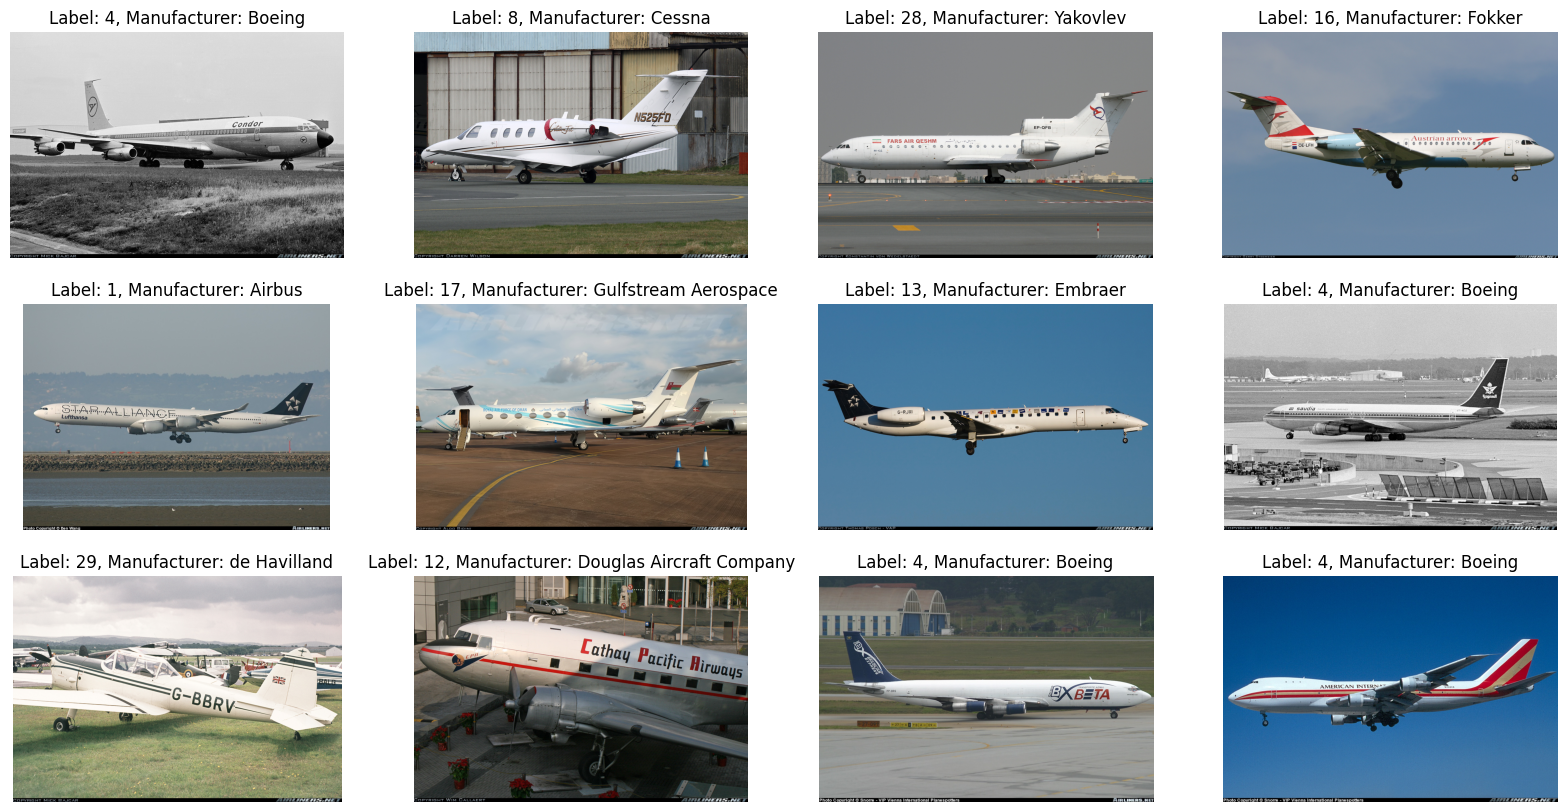

In [9]:
import random
from PIL import Image

# show various manufactuers
def show_images_manu(df, num_images_per_row=5, num_row=3):
    fig, axes = plt.subplots(num_row, num_images_per_row, figsize=(20, 10))
    for i in range(num_images_per_row * num_row):
        index_to_show = random.randint(0, len(df_train_manu) - 1)

        # Get the row corresponding to the chosen index
        image_row = df_train_manu.iloc[index_to_show]
        image_path = image_row['image_path']
        manufacturer_name = image_row['manufacturer_name']
        label = image_row['manufacturer_index']

        img = Image.open(image_path)

        r = i // num_images_per_row
        c = i% num_images_per_row

        # image = image.permute(1, 2, 0)  # convert from CxHxW to HxWxC
        axes[r, c].imshow(img)
        axes[r, c].set_title(f'Label: {label}, Manufacturer: {manufacturer_name}')
        axes[r, c].axis('off')
    plt.show()

show_images_manu(df_train_manu, num_images_per_row=4)

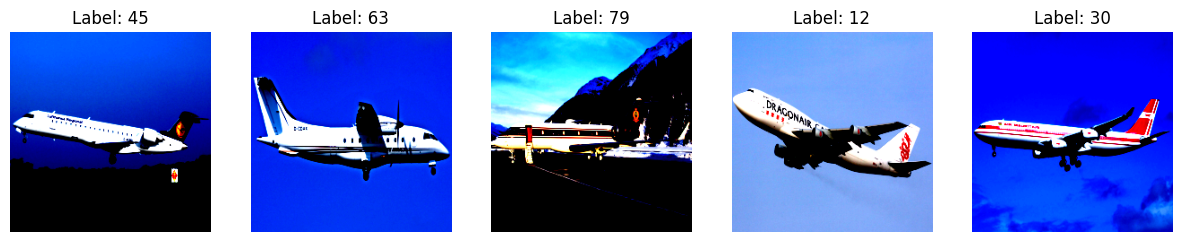

In [10]:
# function to show images
# class_names = train_dataset.classes
# labels = train_dataset._labels

# # Map numerical labels to variant names
# variant_names = [class_names[label_idx] for label_idx in labels]

def show_images(train_dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        image, label = train_dataset[i]
        image = image.permute(1, 2, 0)  # convert from CxHxW to HxWxC
        axes[i].imshow(image)
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')
    plt.show()

show_images(train_dataset, num_images=5)

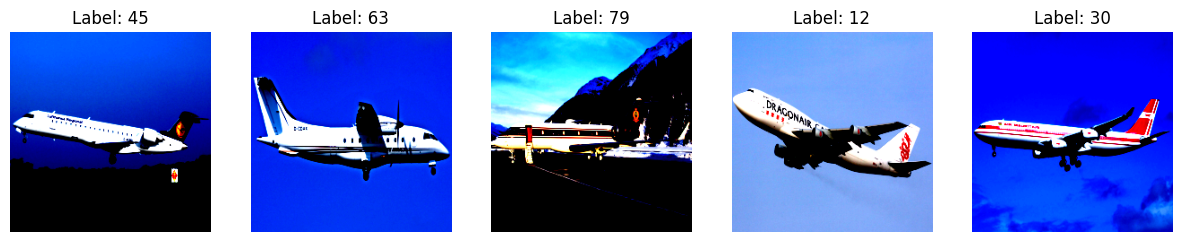

In [11]:
# function to show images
def show_images(train_dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        image, label = train_dataset[i]
        image = image.permute(1, 2, 0)  # convert from CxHxW to HxWxC
        axes[i].imshow(image)
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')
    plt.show()

show_images(train_dataset, num_images=5)

# Create Dataset

In [12]:
TASKS_TOTAL = 3
CLASS_PER_TASKS = 10

In [13]:
from collections import defaultdict
import torch
from tqdm import tqdm

def group_task_indices(dataset, cumulative=False):
    """
    Task 0: 0-9, Task 1: 10-19, ..., Task 9: 90-99
    Output a dictionary where keys are task indices and values are lists of image indices.
    For example, task_dict[0] will contain indices of images with labels 0-9.
    """
    task_dict = defaultdict(list)
    for idx, (_, label) in tqdm(enumerate(dataset), total=len(dataset)):
        # for test and val, should have cumulative indices (all classes seen so far)
        if cumulative:
          for i in range((label // CLASS_PER_TASKS), TASKS_TOTAL):
            task_dict[i].append(idx)
        else:
          task_dict[label // CLASS_PER_TASKS].append(idx)
    return task_dict

# train_task_idxs = group_task_indices(train_dataset)
# val_task_idxs = group_task_indices(val_dataset, cumulative=True)
# test_task_idxs = group_task_indices(test_dataset, cumulative=True)

train_task_idxs = group_task_indices(train_dataset_manu)
val_task_idxs = group_task_indices(val_dataset_manu, cumulative=True)
test_task_idxs = group_task_indices(test_dataset_manu, cumulative=True)

100%|██████████| 3333/3333 [00:42<00:00, 78.45it/s]


In [14]:
labels_dict = defaultdict(int)
for i in val_task_idxs[1]:
    _, label = val_dataset[i]
    labels_dict[label] += 1
print(labels_dict)

defaultdict(<class 'int'>, {53: 15, 90: 17, 41: 10, 11: 10, 58: 7, 36: 14, 81: 10, 67: 7, 24: 10, 94: 15, 4: 11, 3: 11, 49: 13, 17: 9, 98: 10, 80: 9, 59: 10, 54: 12, 57: 12, 60: 16, 25: 8, 39: 8, 37: 19, 15: 13, 13: 13, 64: 7, 63: 10, 34: 14, 77: 9, 84: 10, 76: 13, 46: 15, 91: 16, 99: 10, 27: 9, 56: 8, 83: 14, 73: 11, 66: 11, 32: 14, 2: 10, 96: 15, 62: 8, 70: 9, 16: 9, 42: 12, 40: 10, 69: 14, 92: 9, 7: 14, 79: 12, 18: 8, 61: 4, 19: 10, 30: 12, 93: 10, 5: 13, 12: 13, 97: 7, 29: 13, 26: 13, 74: 10, 33: 12, 55: 8, 52: 12, 47: 11, 28: 15, 38: 6, 43: 7, 88: 9, 50: 12, 22: 6, 9: 12, 44: 13, 71: 9, 82: 10, 14: 8, 75: 12, 1: 7, 72: 9, 10: 9, 89: 9, 21: 11, 85: 14, 48: 12, 31: 14, 95: 12, 68: 9, 86: 11, 65: 9, 51: 11, 35: 9, 6: 4, 23: 9, 8: 7, 78: 10, 45: 10, 0: 5, 20: 8, 87: 6})


## Training Code

In [15]:
def val_net(net_to_val, val_loader):
    net_to_val.eval()
    loss = 0

    criterion = torch.nn.CrossEntropyLoss()

    with torch.no_grad():
        for img, label in tqdm(val_loader, desc="Validating"):

            # Get the input images and their corresponding labels
            img, label = img.cuda(), label.cuda()

            # Forward pass: Get predictions from the model
            outputs = net_to_val(img)

            # compute SmoothL1Losss
            loss += criterion(outputs, label)

        return loss / len(val_loader)

def train_net(max_epochs, freeze_epochs, patience, net_to_train, opt, train_loader, val_loader, task, save_file=None, save_path=None):
    criterion = torch.nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []
    # prepare the net for training
    net_to_train.cuda()

    # freeze backbone
    for param in net_to_train.parameters():
        param.requires_grad = False
    for param in net_to_train.fc.parameters():
        param.requires_grad = True

    # loop over the dataset multiple times
    for epoch in range(max_epochs):
        net_to_train.train()

        running_loss = 0.0

        # unfreeze all layers
        if epoch == freeze_epochs:
          for param in net_to_train.parameters():
              param.requires_grad = True
              # change optimizer learning rate
              opt.param_groups[0]['lr'] = 1e-4

        # train on batches of data
        for imgs, labels in tqdm(train_loader, unit='batch'):

            imgs, labels = imgs.cuda(), labels.cuda()

            # zero the parameter gradients
            opt.zero_grad()

            # prediction
            outputs = net_to_train(imgs)

            # compute the loss
            loss = criterion(outputs, labels)
            loss.backward()
            opt.step()

            # print loss statistics
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        val_losses.append(val_net(net_to_train, val_loader))
        print(f"Epoch {epoch + 1}, Training Loss: {avg_loss:.3f}, Validation Loss: {val_losses[-1]:.3f}")

        # save to checkpoint
        if save_path:
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': net_to_train.state_dict(),
                'optimizer_state_dict': opt.state_dict(),
                'loss': avg_loss,
            }, save_path)
            print(f"Checkpoint saved to {save_path}")

        # save task, trainloss, valloss to file
        if save_file:
            with open(save_file, 'a') as f:
                f.write(f"{task},{epoch + 1},{avg_loss},{val_losses[-1]}\n")

        # early stopping based on patience
        if len(val_losses) > patience and val_losses[-1] >= min(val_losses[:-patience]):
            print(f"Early stopping at epoch {epoch + 1}")
            break

    print("finished training")
    return train_losses, val_losses

In [16]:
import torch.nn as nn
def modify_resnet_head(model, num_classes):
  """
  Modify the last fully connected layer of the ResNet model to match the number of classes.
  """

  old_fc = model.fc
  old_num_classes = old_fc.out_features
  num_ftrs = old_fc.in_features

  # Create the new head
  new_fc = nn.Linear(num_ftrs, num_classes).cuda()

  # Copy weights and biases from the old head
  if old_num_classes < num_classes:
    new_fc.weight.data[:old_num_classes, :] = old_fc.weight.data.clone().cuda()
    new_fc.bias.data[:old_num_classes] = old_fc.bias.data.clone().cuda()

  model.fc = new_fc
  return model

In [17]:
import torch

def get_test_accuracy(model, test_loader, num_classes):
    model.eval()
    correct_preds = 0
    total = 0
    correct_per_class = [0] * num_classes
    total_per_class = [0] * num_classes

    with torch.no_grad():
        for imgs, labels in tqdm(test_loader, desc="Testing", total=len(test_loader)):
            imgs, labels = imgs.cuda(), labels.cuda()
            output = model(imgs)
            preds = output.argmax(dim=1)

            correct_preds += (preds == labels).sum().item()
            total += labels.size(0)

            # Per-class stats
            for c in range(num_classes):
                correct_per_class[c] += ((preds == c) & (labels == c)).sum().item()
                total_per_class[c] += (labels == c).sum().item()

    overall_acc = correct_preds / total
    per_class_acc = [correct_per_class[c] / total_per_class[c] if total_per_class[c] > 0 else 0.0
                     for c in range(num_classes)]
    return overall_acc, per_class_acc


In [ ]:
from torch.utils.data import Subset
from torchvision import models
import torch.optim as optim

# Initialize the model
model = models.resnet18(pretrained=True)

# freeze all parameters except the last fc layer
for name, param in model.named_parameters():
    if name != 'fc.weight' and name != 'fc.bias':
        param.requires_grad = False

# test_loader = torch.utils.data.DataLoader(
#     test_dataset, batch_size=32, shuffle=False, num_workers=4, worker_init_fn=seed_worker, generator=g
# )

# create output file for train and val losses

save_dir = 'naive'

for task in range(CLASS_PER_TASKS):

    print(f"Training on task {task}...")

    model = modify_resnet_head(model, (task+1) * 10)
    model = model.cuda()

    optimizer = optim.Adam(model.parameters(), lr=0.0015)

    train_loader = torch.utils.data.DataLoader(
        Subset(train_dataset_manu, train_task_idxs[task]), batch_size=64, shuffle=True, num_workers=4, worker_init_fn=seed_worker, generator=g
    )
    val_loader = torch.utils.data.DataLoader(
        Subset(val_dataset_manu, val_task_idxs[task]), batch_size=64, shuffle=False, num_workers=4, worker_init_fn=seed_worker, generator=g
    )

    test_loader = torch.utils.data.DataLoader(
        Subset(test_dataset_manu, test_task_idxs[task]), batch_size=64, shuffle=False, num_workers=4, worker_init_fn=seed_worker, generator=g
    )

    # create output file for train and val losses
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Train the model on the current task
    train_losses, val_losses = train_net(15, 5, 5, model, optimizer, train_loader, val_loader, task, save_file=os.path.join(save_dir, 'train_val_losses.txt'))

    # Evaluate the model on the test set
    overall_acc, per_class_acc = get_test_accuracy(model, test_loader, (task+1) * 10)
    print(f"Overall accuracy for task {task}: {overall_acc:.4f}")
    print(f"Per-class accuracy for task {task}: {per_class_acc}")

    # save to text file in save dir
    if not os.path.exists(os.path.join(save_dir, 'accuracies.txt')):
        with open(os.path.join(save_dir, 'accuracies.txt'), 'w') as f:
            f.write("Task,Overall Accuracy,Per-Class Accuracy\n")
    with open(os.path.join(save_dir, 'accuracies.txt'), 'a') as f:
        f.write(f"{task},{overall_acc:.4f},{per_class_acc}\n")

    # Save the model after training on each task in save dir
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    torch.save(model.state_dict(), os.path.join(save_dir, f"model_task_{task}.pth"))
    print(f"Model for task {task} saved as model_task_{task}.pth")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training on task 0...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validating: 100%|██████████| 12/12 [00:10<00:00,  1.15it/s]


Epoch 1, Training Loss: 1.661, Validation Loss: 1.380


Validating: 100%|██████████| 12/12 [00:09<00:00,  1.33it/s]


Epoch 2, Training Loss: 1.239, Validation Loss: 1.176


Validating: 100%|██████████| 12/12 [00:09<00:00,  1.31it/s]


Epoch 3, Training Loss: 1.055, Validation Loss: 1.075


Validating: 100%|██████████| 12/12 [00:09<00:00,  1.29it/s]


Epoch 4, Training Loss: 0.934, Validation Loss: 1.008


Validating: 100%|██████████| 12/12 [00:09<00:00,  1.29it/s]


Epoch 5, Training Loss: 0.873, Validation Loss: 0.960


Validating: 100%|██████████| 12/12 [00:08<00:00,  1.36it/s]


Epoch 6, Training Loss: 0.615, Validation Loss: 0.452


Validating: 100%|██████████| 12/12 [00:09<00:00,  1.30it/s]


Epoch 7, Training Loss: 0.093, Validation Loss: 0.412


Validating: 100%|██████████| 12/12 [00:08<00:00,  1.46it/s]


Epoch 8, Training Loss: 0.021, Validation Loss: 0.386


Validating: 100%|██████████| 12/12 [00:09<00:00,  1.31it/s]


Epoch 9, Training Loss: 0.009, Validation Loss: 0.371


Validating: 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]


Epoch 10, Training Loss: 0.005, Validation Loss: 0.366


Validating: 100%|██████████| 12/12 [00:09<00:00,  1.30it/s]


Epoch 11, Training Loss: 0.004, Validation Loss: 0.375


Validating: 100%|██████████| 12/12 [00:10<00:00,  1.18it/s]


Epoch 12, Training Loss: 0.003, Validation Loss: 0.385


Validating: 100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


Epoch 13, Training Loss: 0.003, Validation Loss: 0.363


Validating: 100%|██████████| 12/12 [00:09<00:00,  1.27it/s]


Epoch 14, Training Loss: 0.002, Validation Loss: 0.386
Early stopping at epoch 14
finished training


Testing: 100%|██████████| 29/29 [00:20<00:00,  1.38it/s]


Overall accuracy for task 0: 0.8739
Per-class accuracy for task 0: [0.9253731343283582, 0.7274826789838337, 0.9393939393939394, 0.8939393939393939, 0.946866485013624, 0.7272727272727273, 0.8120300751879699, 0.8947368421052632, 0.9626865671641791, 0.9117647058823529]
Model for task 0 saved as model_task_0.pth
Training on task 1...


Validating: 100%|██████████| 17/17 [00:12<00:00,  1.32it/s]


Epoch 1, Training Loss: 2.079, Validation Loss: 4.729


Validating: 100%|██████████| 17/17 [00:13<00:00,  1.30it/s]


Epoch 2, Training Loss: 1.219, Validation Loss: 5.448


Validating: 100%|██████████| 17/17 [00:13<00:00,  1.30it/s]


Epoch 3, Training Loss: 0.929, Validation Loss: 5.519


Validating: 100%|██████████| 17/17 [00:13<00:00,  1.30it/s]


Epoch 4, Training Loss: 0.798, Validation Loss: 5.476


Validating: 100%|██████████| 17/17 [00:14<00:00,  1.15it/s]


Epoch 5, Training Loss: 0.724, Validation Loss: 5.459


Validating: 100%|██████████| 17/17 [00:13<00:00,  1.31it/s]


Epoch 6, Training Loss: 0.514, Validation Loss: 6.054
Early stopping at epoch 6
finished training


Testing: 100%|██████████| 41/41 [00:31<00:00,  1.30it/s]


Overall accuracy for task 1: 0.2757
Per-class accuracy for task 1: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9253731343283582, 0.8787878787878788, 0.8872180451127819, 0.9871244635193133, 1.0, 0.8235294117647058, 0.85, 0.835820895522388, 0.9411764705882353, 0.6515151515151515]
Model for task 1 saved as model_task_1.pth
Training on task 2...


Validating: 100%|██████████| 21/21 [00:16<00:00,  1.26it/s]


Epoch 1, Training Loss: 2.433, Validation Loss: 10.728


Validating: 100%|██████████| 21/21 [00:15<00:00,  1.31it/s]


Epoch 2, Training Loss: 1.089, Validation Loss: 11.964


Validating: 100%|██████████| 21/21 [00:17<00:00,  1.23it/s]


Epoch 3, Training Loss: 0.787, Validation Loss: 12.246


Validating: 100%|██████████| 21/21 [00:15<00:00,  1.32it/s]


Epoch 4, Training Loss: 0.662, Validation Loss: 12.076


 42%|████▏     | 8/19 [00:06<00:05,  2.09batch/s]